In [1]:
import pandas as pd
import numpy as np
import scipy
from pykalman.pykalman import *
import control

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=1.5)
from statannotations.Annotator import Annotator
import statsmodels.formula.api as smf
import statsmodels as stats

import prep_emotioncon 
import emotioncon_modelling
import emotioncon_stats
import auxiliary

In [2]:
emo = emotioncon_modelling.Modelling()
emostats = emotioncon_stats.Statistics()
prep = prep_emotioncon.PrepEmotioncon()
aux = auxiliary.Auxiliary()
attention_cr = np.array([1, 0, 0, 1, 1, 1, 1, 0, 0, 0])
mood_categories = ['disgusted', 'amused', 'calm', 'anxious', 'sad']
filepath = '../'
data = np.load(filepath + 'results/data_experiment.npy',allow_pickle='TRUE')
savefig = True
palette= {0: "plum", 1: "purple", 2: "lightgrey", 3: "grey"}

In [3]:
# make inputs ready
input_df = pd.read_csv(filepath + 'experiment/public/prep/videosForExperiment.csv')
inp_dummies = pd.get_dummies(input_df['category'])
inp_dummies = inp_dummies.reindex(columns=['Disgust', 'Amusement', 'Calmness', 'Anxiety', 'Sadness'])
inp = inp_dummies.values
inp = np.vstack([np.zeros(np.shape(inp)[1]), inp, np.zeros(np.shape(inp)[1]), inp])

In [4]:
data = np.load(filepath + 'results/fit_experiment.npy',allow_pickle='TRUE')
df, mood_ratings, foo = prep.create_df_from_dict(data)
dynamics, controls = prep.rearrange_data_for_stats(data)
Nsj = len(data)
print('N = ' + str(Nsj))

N = 108


/Users/jolandamalamud/phd/papers/git/emotioncon_public/analyses/prep_emotioncon.py:119: RuntimeWarning: invalid value encountered in log
  dynamics['HL'][:,sj,k] = np.log(0.5) / np.log(e)


In [5]:
# outlier Detection (IQR)
def detect_outlier(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    ex = np.where((data >= (Q1-1.5*IQR))&(data >= (Q3+1.5*IQR)))[0]
    print(Q1-1.5*IQR, Q3+1.5*IQR)
    return ex

In [6]:
# outlier detection based on singular values in controllability matrix
ex = detect_outlier(controls['val'][0,:,:])
ex

(-519.8066256074557+0j) (1263.539578100499+0j)


array([18, 40])

In [7]:
# exclude outliers due to fit
data = np.delete(data,ex)
Nsj = len(data)
print('N = ' + str(Nsj))
np.save(filepath + 'results/fit_experiment_included.npy', data)
df, mood_ratings, foo = prep.create_df_from_dict(data)
dynamics, controls = prep.rearrange_data_for_stats(data)
print('number in distancing group: ' + str(df['randomized_condition'].sum()))

N = 106
number in distancing group: 55.0


In [35]:
# simulate individual data from fitted kalman filter
import copy
def simulate_data(data, kf_before, kf_after, inp, mood_ratings):
    mood_ratings_split = np.empty((int(np.shape(mood_ratings)[0]/2), \
                                   np.shape(mood_ratings)[1], np.shape(mood_ratings)[2], 2))
    T = np.shape(data[0]['ratings'])[1]
    t = 1
    inp_split = inp[t*int(T/2):t*int(T/2) + int(T/2),:]
    for sj in range(Nsj):
        for t in range(2):
            if (t==0):
                subject_kf = copy.copy(data[sj]['results_split'][kf_before])
            elif (t==1):
                subject_kf = copy.copy(data[sj]['results_split'][kf_after])
            foo, x = subject_kf.sample(int(T/2),  initial_state=data[sj]['ratings'][:,t*int(T/2)], \
                                                        control_inputs=inp_split)
            mood_ratings_split[:,:,sj,t] = x
    return mood_ratings_split
    
def plot_simulated_data_and_stats(mood_ratings_split, df, mood_categories):
    label= ['mean', 'variance']
    pairs = []
    for t in range(2):
        for i in mood_categories:
            pairs.append([(i, 0+t), (i, 2+t)])
            pairs.append([(i, t+(t*1)), (i, t+(t*1)+1)])

    df_stats_both = pd.DataFrame()
    for j, i in enumerate([np.nanmean(mood_ratings_split,axis=0), np.nanvar(mood_ratings_split,axis=0)]):
        df_stats, pvalues, tvalues = emostats.stats_group_difference(i, df)
        df_plot = emostats.make_df(i, df, mood_categories)
        fig, ax = plt.subplots(figsize=(20,8))
        fig, ax = emostats.plot_group_difference(df=df_plot, data_labels=mood_categories, \
                                                 data_name=label[j] + ' ratings' , pairs=pairs, fig=fig, ax=ax, \
                                                ms=False, showfliers=False)
        ax.set(ylabel=label[j] + ' ratings')
        df_stats_both = pd.concat((df_stats_both, df_stats), axis=1)

    display(df_stats_both)

,T2,Fstats,pvalue,T2,Fstats,pvalue
before intervention,11.32,2.18,0.063,8.26,1.59,0.17
after intervention,20.76,3.99,0.002,45.32,8.72,< 0.001
change (after - before),40.64,7.81,< 0.001,21.62,4.16,0.002


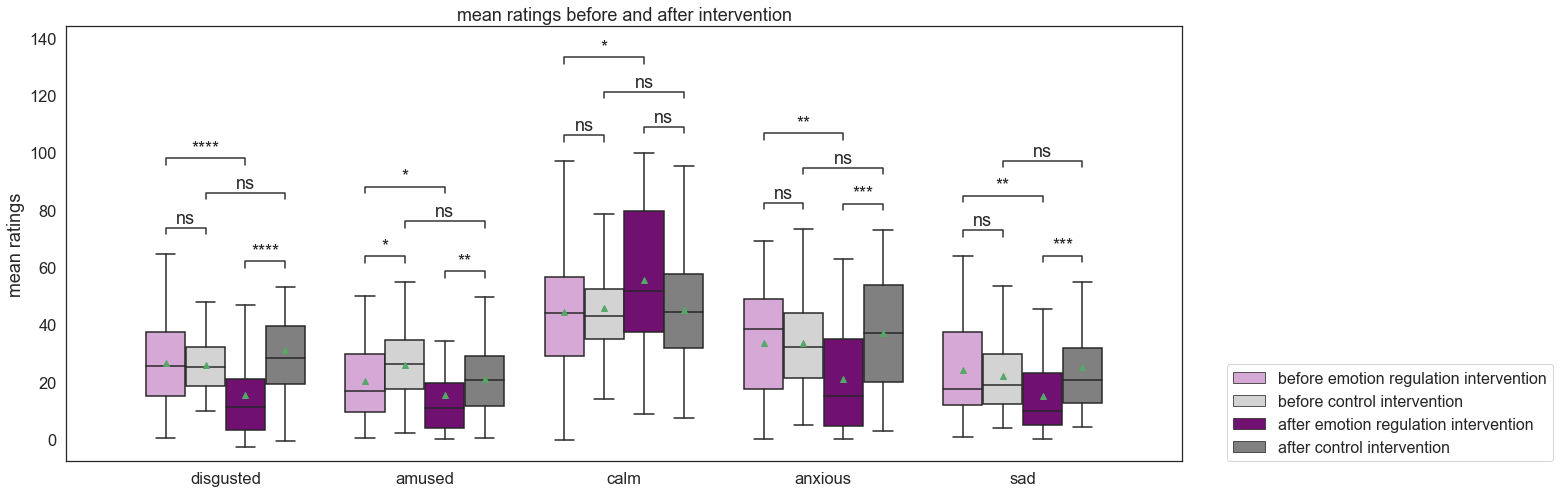

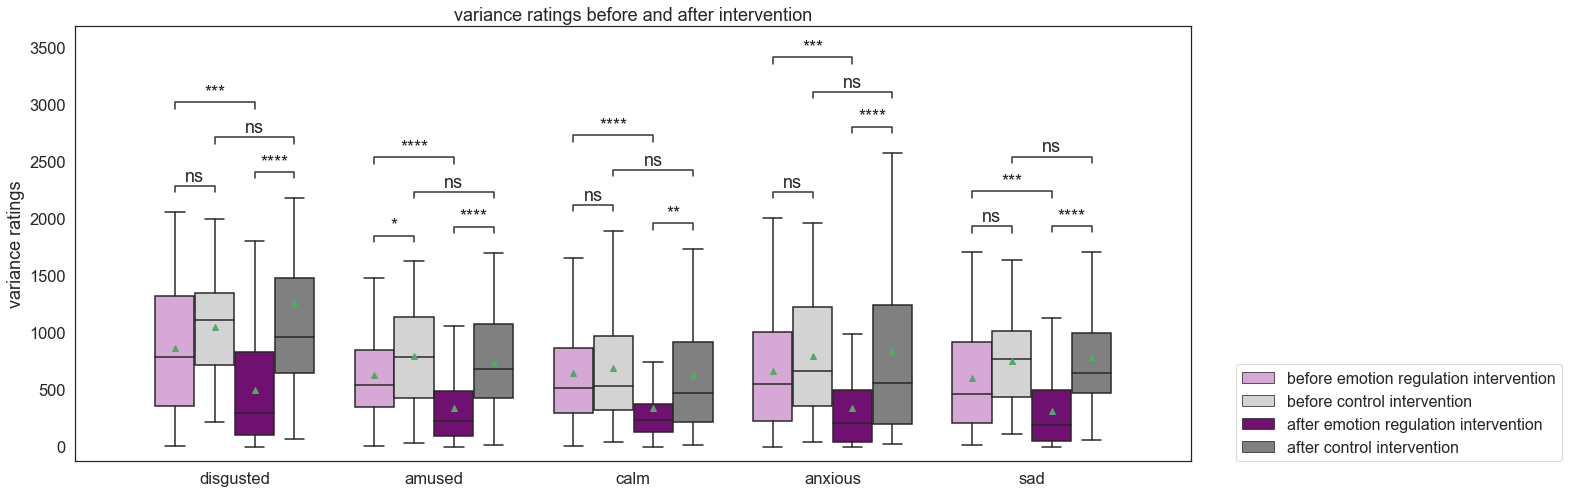

In [36]:
# simulated mean and variance difference effect due to distancing - winning model
mood_ratings_split = simulate_data(data, 13, 14, inp, mood_ratings)
plot_simulated_data_and_stats(mood_ratings_split, df, mood_categories)

,T2,Fstats,pvalue,T2,Fstats,pvalue
before intervention,3.57,0.69,0.634,17.90,3.44,0.007
after intervention,15.29,2.94,0.016,26.89,5.17,< 0.001
change (after - before),16.47,3.17,0.011,8.44,1.62,0.161


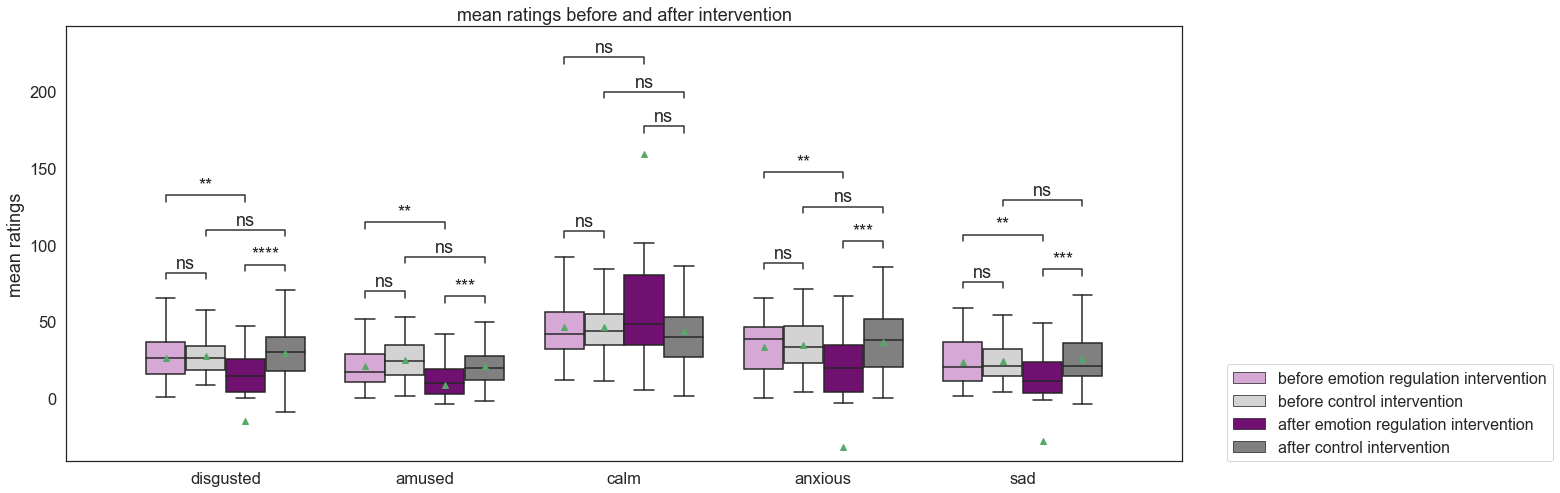

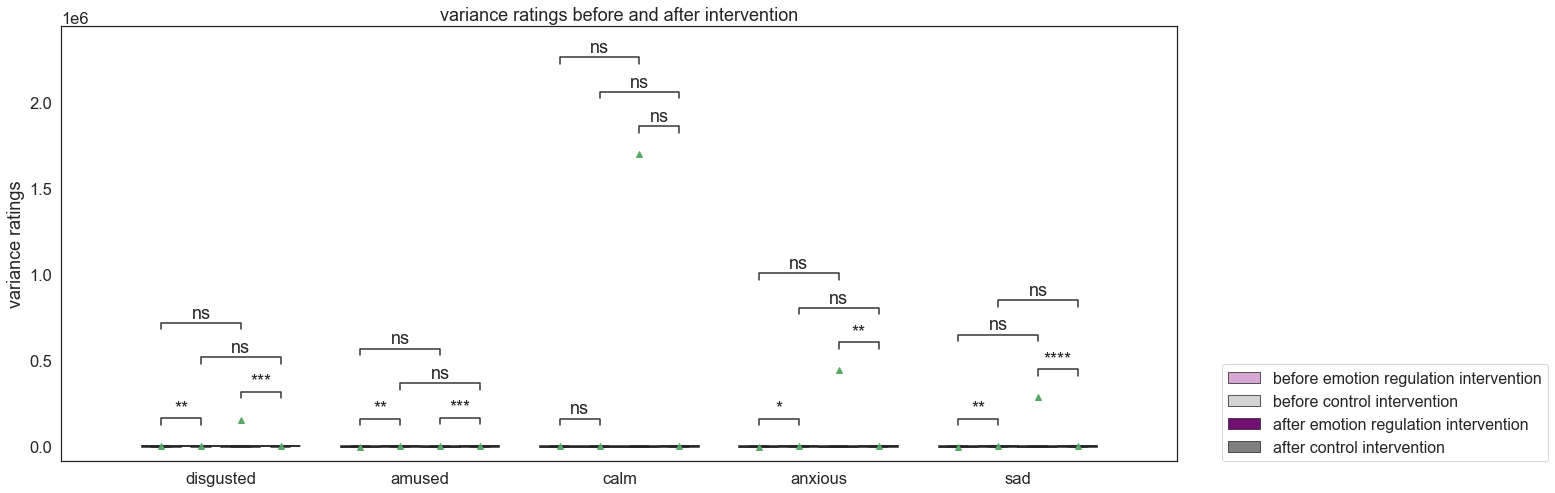

In [37]:
# simulated mean and variance difference effect due to distancing - only A can change
mood_ratings_split = simulate_data(data, 1, 2, inp, mood_ratings)
plot_simulated_data_and_stats(mood_ratings_split, df, mood_categories)

,T2,Fstats,pvalue,T2,Fstats,pvalue
before intervention,7.25,1.39,0.233,16.87,3.24,0.009
after intervention,16.24,3.12,0.012,28.34,5.45,< 0.001
change (after - before),26.74,5.14,< 0.001,14.03,2.70,0.025


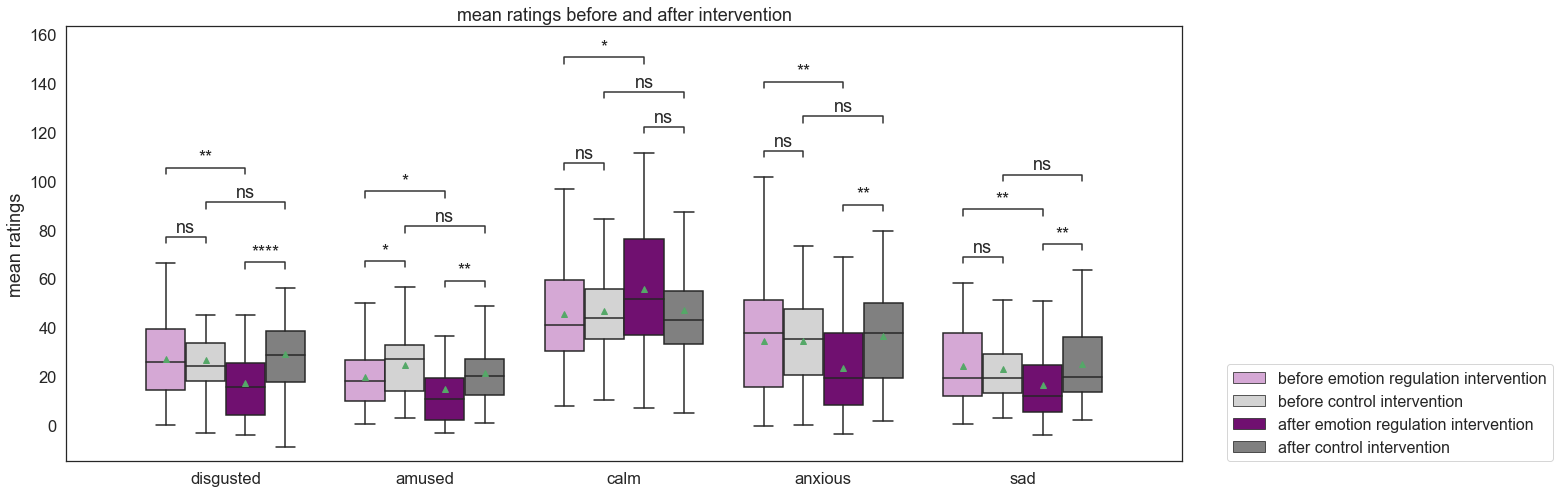

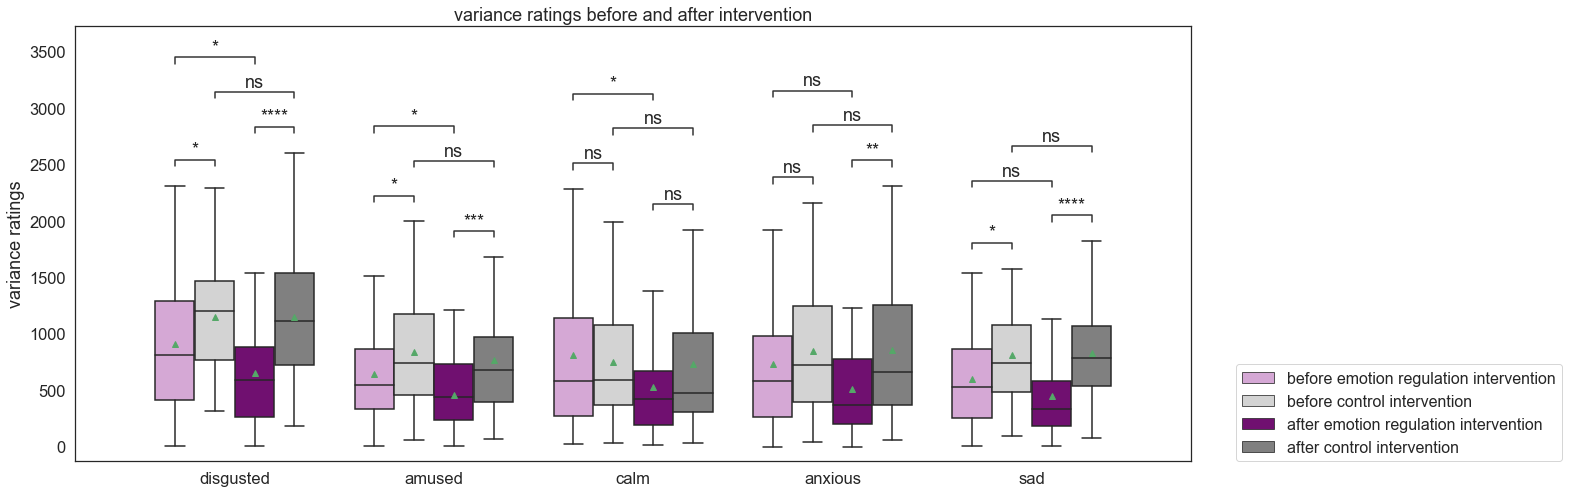

In [38]:
# simulated mean and variance difference effect due to distancing - only A can change
mood_ratings_split = simulate_data(data, 3, 4, inp, mood_ratings)
plot_simulated_data_and_stats(mood_ratings_split, df, mood_categories)